In [16]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import os

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, '')
STATE_SIZE = 10

In [2]:
!git clone https://github.com/backgom2357/Recommender_system_via_deep_RL.git

Cloning into 'Recommender_system_via_deep_RL'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 403 (delta 6), reused 7 (delta 2), pack-reused 385
Receiving objects: 100% (403/403), 58.39 MiB | 26.97 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [84]:
%cd Recommender_system_via_deep_RL/

In [85]:
%cd data

/content/Recommender_system_via_deep_RL/data


In [86]:
users_df = pd.read_csv('./BX-Users.csv', sep=';', encoding='latin-1')
ratings_df = pd.read_csv('./BX-Book-Ratings.csv', sep=';', encoding='latin-1')
books_df = pd.read_csv('./Books.csv', sep=';', encoding='latin-1')

# Book-Crossing dataset EDA

In [87]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


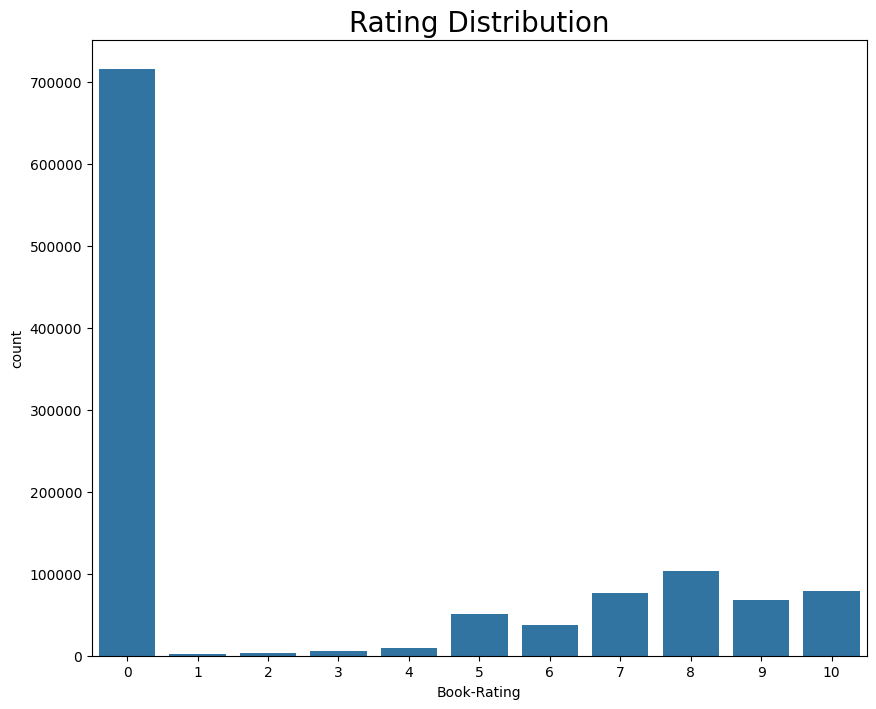

In [88]:
plt.figure(figsize=(10,8))
sns.countplot(x='Book-Rating',data=ratings_df)
plt.title('Rating Distribution',size=20)
plt.show()

In [89]:
books_df.head()

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


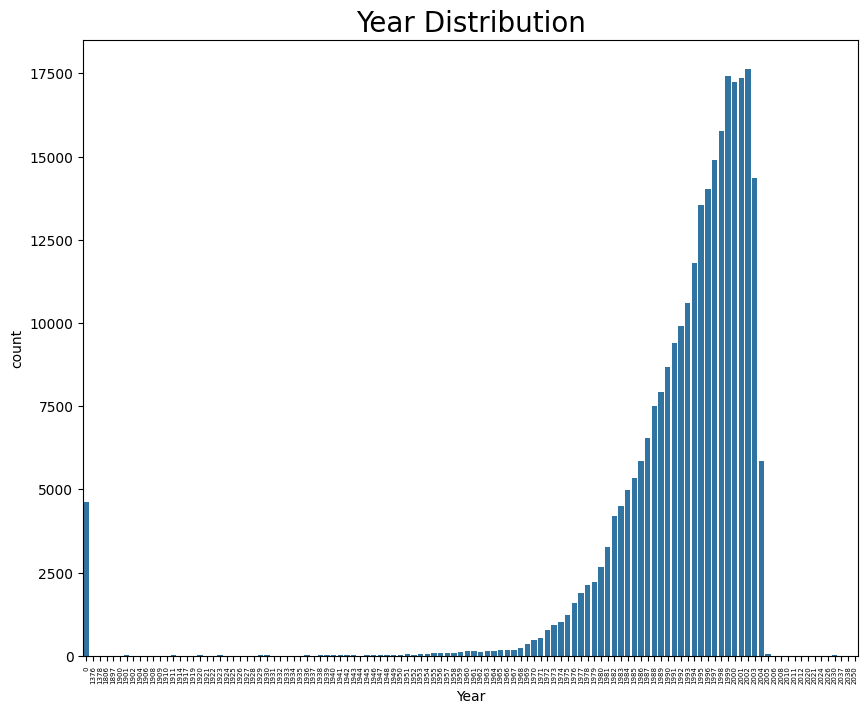

In [90]:
plt.figure(figsize=(10,8))
sns.countplot(x='Year',data=books_df)
plt.xticks(rotation=90, fontsize=5)
plt.title('Year Distribution',size=20)
plt.show()

In [91]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [92]:
max(users_df['User-ID'])+1

278859

### Create a mapping of book ISBNs to Book titles

In [93]:
books_id_to_books = {book[0]: book[1] for book in books_df[['ISBN', 'Title']].values}
ratings_df['ISBN'] = ratings_df['ISBN'].map(books_id_to_books)

In [94]:
books_id_to_books

{'0195153448': 'Classical Mythology',
 '0002005018': 'Clara Callan',
 '0060973129': 'Decision in Normandy',
 '0374157065': 'Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It',
 '0393045218': 'The Mummies of Urumchi',
 '0399135782': "The Kitchen God's Wife",
 '0425176428': "What If?: The World's Foremost Military Historians Imagine What Might Have Been",
 '0671870432': 'PLEADING GUILTY',
 '0679425608': 'Under the Black Flag: The Romance and the Reality of Life Among the Pirates',
 '074322678X': "Where You'll Find Me: And Other Stories",
 '0771074670': 'Nights Below Station Street',
 '080652121X': "Hitler's Secret Bankers: The Myth of Swiss Neutrality During the Holocaust",
 '0887841740': 'The Middle Stories',
 '1552041778': 'Jane Doe',
 '1558746218': "A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series)",
 '1567407781': 'The Witchfinder (Amos Walker Mystery Series)',
 '1575663937': 'More Cunning Than Man: A Social

In [95]:
books_id_to_books['0375759778']

'Prague : A Novel'

In [96]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,Flesh Tones: A Novel,0
1,276726,Rites of Passage,5
2,276727,The Notebook,0
3,276729,Help!: Level 1,3
4,276729,The Amsterdam Connection : Level 4 (Cambridge ...,6


### Reconfiguring the User-IDs to I,2,3...... and dividing ratings by 2 to scale ratings from 10 to 5 for uniformity between datasets

In [97]:
user_mapping = {}
new_user_id = 1
for old_user_id in ratings_df['User-ID'].unique():
    user_mapping[old_user_id] = new_user_id
    new_user_id += 1
ratings_df['User-ID'] = ratings_df['User-ID'].map(user_mapping)
ratings_df['Book-Rating']=(ratings_df['Book-Rating']//2)

In [98]:
ratings_df.tail(10)

,User-ID,ISBN,Book-Rating
1149770,105279,A Desert of Pure Feeling (Vintage Contemporaries),0
1149771,105279,Dreamcatcher,3
1149772,105279,All I Really Need to Know,0
1149773,105279,Perplexing Lateral Thinking Puzzles: Scholasti...,2
1149774,105279,Edgar Cayce on the Akashic Records: The Book o...,0
1149775,105279,Get Clark Smart : The Ultimate Guide for the S...,4
1149776,105280,Eight Weeks to Optimum Health: A Proven Progra...,0
1149777,105281,The Sherbrooke Bride (Bride Trilogy (Paperback)),5
1149778,105282,Fourth Grade Rats,5
1149779,105283,NaN,4


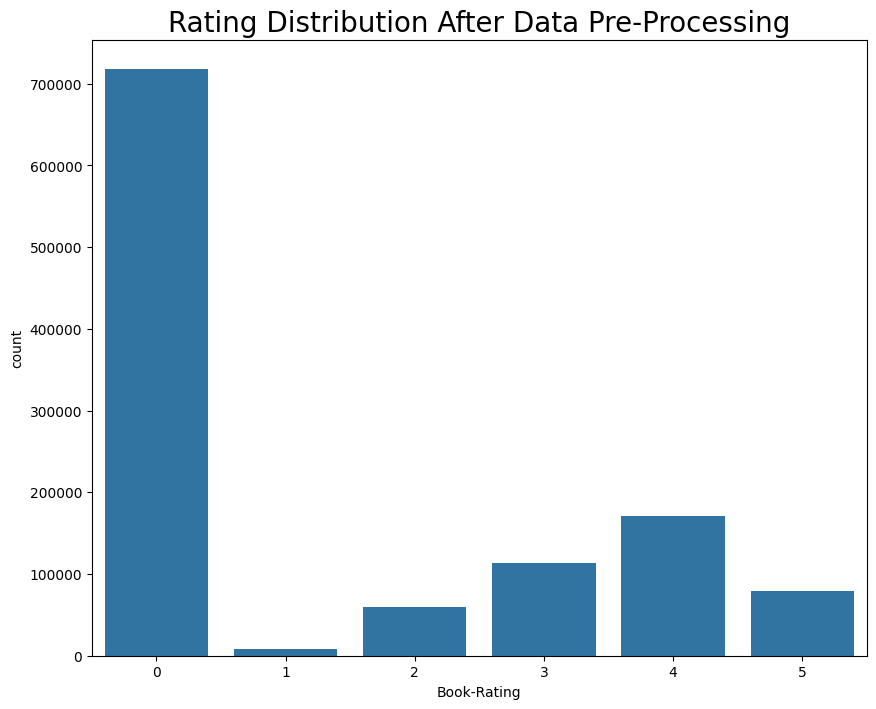

In [138]:
plt.figure(figsize=(10,8))
sns.countplot(x='Book-Rating',data=ratings_df)
plt.title('Rating Distribution After Data Pre-Processing',size=20)
plt.show()

## Creating User_dict.npy

In [100]:
user_dict = {}
for index, row in ratings_df.iterrows():
    user_id = row['User-ID']
    book_id = row['ISBN']
    rating = row['Book-Rating']
    if user_id not in user_dict:
        user_dict[user_id] = []
    user_dict[user_id].append((book_id, rating))


In [101]:
np.save('user_dict_books.npy',user_dict )

Ratings given by user-id 10

In [102]:
user_dict[10]

[('Lightning', 0),
 ('Manhattan Hunt Club', 0),
 ('Dark Paradise', 0),
 ('Night Sins', 0),
 ('At the Edge', 0),
 ('Make Them Cry', 0)]

In [103]:
user_book_counts = ratings_df.groupby('User-ID')['ISBN'].count().values
user_book_counts_array = np.array(user_book_counts)

In [104]:
np.save("usesr_history_len_books.npy", user_book_counts)

In [105]:
usr_dict = np.load('user_dict_books.npy', allow_pickle=True)

The no. of books they have rated

In [106]:
usr_history_len = np.load("usesr_history_len_books.npy")

In [107]:
users_num = max(ratings_df["User-ID"])+1
items_num = (ratings_df["ISBN"].nunique())+1

In [108]:
users_num

105284

In [56]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [109]:
cd ./../

/content/Recommender_system_via_deep_RL


In [110]:
#unique_users = ratings_df['User-ID'].unique()[:6040]
#ratings_df = ratings_df[ratings_df['User-ID'].isin(unique_users)]

In [111]:
users_num = max(ratings_df["User-ID"])+1
items_num = (ratings_df["ISBN"].nunique())+1

UNIQUE USERS

In [112]:
users_num

105284

In [166]:
len(ratings_df)

1149780

ratings with titles instead of ISBNs

In [113]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,1,Flesh Tones: A Novel,0
1,2,Rites of Passage,2
2,3,The Notebook,0
3,4,Help!: Level 1,1
4,4,The Amsterdam Connection : Level 4 (Cambridge ...,3


In [122]:
!python train.py

Data loading...
Data loading complete!
Data preprocessing...
DONE!


In [115]:
ratings_df.isnull().sum()

User-ID             0
ISBN           118605
Book-Rating         0
dtype: int64

In [116]:

# len(set(ratings_df["User-ID"])) gives the number of unique user IDs in the DataFrame.
# max([int(i) for i in set(ratings_df["User-ID"])]) finds the maximum user ID in the DataFrame.
# If the two values are equal, it means that the user IDs are sequential and there are no missing user IDs.

print(len(set(ratings_df["User-ID"])) == max([int(i) for i in set(ratings_df["User-ID"])]))
print(max([int(i) for i in set(ratings_df["User-ID"])]))

True
105283


In [129]:
books_df.head()

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


In [117]:
train_users_num = int(users_num * 0.8)
train_items_num = items_num
print(train_users_num, train_items_num)

84227 241091


In [134]:
train_users_dict = {k:usr_dict[k] for k in range(1, train_users_num+1)}
train_users_history_lens = usr_history_len[:train_users_num]

In [119]:
eval_users_num = int(users_num * 0.2)
eval_items_num = items_num
print(eval_users_num, eval_items_num)

21056 241091


In [140]:
eval_users_dict = {k:usr_dict[k] for k in range(users_num-eval_users_num, users_num)}
eval_users_history_lens = usr_history_len[-eval_users_num:]

In [140]:
def evaluate(recommender, env, check_movies = False, top_k=False):
    episode_reward = 0
    steps = 0
    mean_precision = 0
    mean_ndcg = 0
    user_id, items_ids, done = env.reset()
    if check_movies:
        print(f'user_id : {user_id}, rated_items_length:{len(env.user_items)}')
        print('items : \n', np.array(env.get_items_names(items_ids)))

    while not done:
        user_eb = recommender.embedding_network.get_layer('user_embedding')(np.array(user_id))
        items_eb = recommender.embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_eb, axis=0)])
        action = recommender.actor.network(state)
        recommended_item = recommender.recommend_item(action, env.recommended_items, top_k=top_k)
        if check_movies:
            print(f'recommended items ids : {recommended_item}')
            print(f'recommened items : \n {np.array(env.get_items_names(recommended_item), dtype=object)}')
        next_items_ids, reward, done, _ = env.step(recommended_item, top_k=top_k)
        if top_k:
            correct_list = [1 if r > 0 else 0 for r in reward]
            # ndcg
            dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(reward))])
            mean_ndcg += dcg/idcg

            #precision
            correct_num = top_k-correct_list.count(0)
            mean_precision += correct_num/top_k

        reward = np.sum(reward)
        items_ids = next_items_ids
        episode_reward += reward
        steps += 1

        if check_movies:
            print(f'precision : {correct_num/top_k}, dcg : {dcg:0.3f}, idcg : {idcg:0.3f}, ndcg : {dcg/idcg:0.3f}, reward : {reward}')
            print()
        break

    if check_movies:
        print(f'precision : {mean_precision/steps}, ngcg : {mean_ndcg/steps}, episode_reward : {episode_reward}')
        print()

    return mean_precision/steps, mean_ndcg/steps

def calculate_ndcg(rel, irel):
    dcg = 0
    idcg = 0
    rel = [1 if r>0 else 0 for r in rel]
    for i, (r, ir) in enumerate(zip(rel, irel)):
        dcg += (r)/np.log2(i+2)
        idcg += (ir)/np.log2(i+2)
    return dcg, idcg

In [135]:
from envs import OfflineEnv
from recommender import DRRAgent

sum_precision = 0
sum_ndcg = 0
TOP_K = 10

for user_id in eval_users_dict.keys():
    env = OfflineEnv(eval_users_dict, usr_history_len, books_id_to_books, STATE_SIZE, fix_user_id=user_id)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    ## LOADING THE WEIGHTS OBTAINED AFTER TRAINING FOR 1000 EPOCHS FOR EVALUATION
    recommender.load_model('./actor_1000_fixed.h5',
                           './critic_1000_fixed.h5')
    precision, ndcg = evaluate(recommender, env, top_k=TOP_K)
    sum_precision += precision
    sum_ndcg += ndcg

print(f'precision@{TOP_K} : {sum_precision/len(eval_users_dict)}, ndcg@{TOP_K} : {sum_ndcg/len(eval_users_dict)}')

precision@10 : 0.1856760185376006, ndcg@10 : 0.1621233444676889


In [163]:
TOP_K = 3 # chose any k value as you want

sum_precision = 0
sum_ndcg = 0

end_evaluation = 10

for i, user_id in enumerate(eval_users_dict.keys()):
    env = OfflineEnv(eval_users_dict, usr_history_len, books_id_to_books, STATE_SIZE, fix_user_id=user_id)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    recommender.load_model('./actor_1000_fixed.h5',
                           './critic_1000_fixed.h5')
    precision, ndcg = evaluate(recommender, env, check_movies=True, top_k=TOP_K) # if check movies is true, you can check the recommended movies
    sum_precision += precision
    sum_ndcg += ndcg

    if i > end_evaluation:
        break

print(f'precision@{TOP_K} : {sum_precision/len(eval_users_dict)}, ndcg@{TOP_K} : {sum_ndcg/len(eval_users_dict)}')

User-ID : 571, rated_items_length:11
items : 
['Wild Animus (2004)', 'Rich Shapero']
['Isle of Dogs (2002)', 'Patricia Cornwell']
['Russendisko. (2002)', 'Wladimir Kaminer']
['4 Blondes (2002)', 'Candace Bushnell']
['Portrait of a Killer: Jack the Ripper -- Case Closed (2002)', 'Patricia Cornwell']
['Four Blondes (2001)', 'Candace Bushnell']
['Free (2003)', 'Paul Vincent']
['Sex & the City (1997)', 'Candace Bushnell']
['While I Was Gone (1999)', 'Sue Miller']
['High Maintenance (2002)', 'Jennifer Belle']

recommended items ids : [0842329218 0842329218 0842329218]
recommened items : 
['The Street Lawyer (1999)', 'JOHN GRISHAM']
['Me Talk Pretty One Day (2001)', 'David Sedaris']
['Tribulation Force: The Continuing Drama of Those Left Behind (Left Behind No. 2) (1997)', 'Tim LaHaye']

precision : 0.1456760185376006, ngcg : 0.15463936301137822, episode_reward : -0.5

precision@3 : 0.0041390728476821195, ndcg@3 : 0.0038939719280083897


## COMPILING FINAL CODEBASE

In [164]:
!zip -r /content/DRL_Complete_Books.zip /content/Recommender_system_via_deep_RL

  adding: content/Recommender_system_via_deep_RL/ (stored 0%)
  adding: content/Recommender_system_via_deep_RL/replay_buffer.py (deflated 72%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/ (stored 0%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/critic.cpython-310.pyc (deflated 50%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/replay_buffer.cpython-310.pyc (deflated 47%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/actor.cpython-310.pyc (deflated 48%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/tree.cpython-310.pyc (deflated 55%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/embedding.cpython-310.pyc (deflated 49%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/replay_memory.cpython-310.pyc (deflated 47%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/envs.cpython-310.pyc (deflated 50%)
  adding: content/Recommender_system_via_deep_RL/__pycache__/recommender.cpyth

In [165]:
from google.colab import files
files.download("/content/DRL_Complete_Books.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>